#1. Project Summary

In this project, we used a Decision Tree model to predict whether a person earns more than $50,000 per year. We first converted continuous features into categories (bins) to make the model easier to understand and to reduce overfitting.

We tested different hyperparameters, including split criterion, tree depth, minimum samples per leaf, and number of features. The best model used entropy, maximum depth of 10, and at least 20 samples per leaf.

The final tree has depth 10 and 307 leaves, which shows moderate complexity but is not fully grown. The model trained very quickly (about 0.06 seconds). For the test individual, the model predicted income ≤ $50K with 93.88% probability, showing strong confidence in its prediction.

# 2. Data Foundation Process

## 2-1. Data Loading & Import Libraries

In [107]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import plot_tree

import matplotlib.pyplot as plt
import time
import graphviz


In [108]:
def load_data(url: str) -> pd.DataFrame:
    return pd.read_csv(url)


## 2-2. Data Quality Analysis (DQA)

In [109]:
def describe_data(df: pd.DataFrame) -> pd.DataFrame:
    return df.describe(include="all")


In [110]:
def make_dqa_report(df: pd.DataFrame) -> pd.DataFrame:
    report = pd.DataFrame({
        "column": df.columns,
        "dtype": [df[c].dtype for c in df.columns],
        "missing_count": [df[c].isna().sum() for c in df.columns],
        "missing_pct": [df[c].isna().mean() * 100 for c in df.columns],
        "unique_count": [df[c].nunique(dropna=True) for c in df.columns],
        "example_values": [", ".join(df[c].dropna().astype(str).unique()[:3]) for c in df.columns]
    })
    return report.sort_values("missing_count", ascending=False).reset_index(drop=True)


## 2-3. Data Cleaning & Preparation

In [111]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df2 = df.copy()
    df2 = df2.replace("?", np.nan)

    for c in df2.select_dtypes(include="object").columns:
        df2[c] = df2[c].astype(str).str.strip()

    df2 = df2.dropna().reset_index(drop=True)
    return df2


## 2-4. Target Variable & Feature Construction

In [112]:
def detect_target_and_split_columns(df: pd.DataFrame):
    """
    CA03 census_data.csv (your uploaded file) uses:
    - target: 'y'
    - split:  'flag'  (train/test)
    """
    target_col = "y"
    split_col = "flag"

    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found. Columns are: {df.columns.tolist()}")

    if split_col not in df.columns:
        raise ValueError(f"Split column '{split_col}' not found. Columns are: {df.columns.tolist()}")

    return target_col, split_col


## 2-5. Train/Test Split (Using Provided Split Column)

In [113]:
def split_train_test(df: pd.DataFrame, X: pd.DataFrame, y: pd.Series, split_col: str):
    split_vals = df[split_col].astype(str).str.lower()
    train_mask = split_vals == "train"
    test_mask = split_vals == "test"

    X_train = X.loc[train_mask]
    X_test = X.loc[test_mask]
    y_train = y.loc[train_mask]
    y_test = y.loc[test_mask]

    return X_train, X_test, y_train, y_test


## 2-6 Train/Test Split — Functions

In [114]:
def split_train_test(df: pd.DataFrame, X: pd.DataFrame, y: pd.Series, split_col: str):
    train_mask = df[split_col] == 1
    test_mask = df[split_col] == 0

    X_train = X.loc[train_mask]
    X_test = X.loc[test_mask]
    y_train = y.loc[train_mask]
    y_test = y.loc[test_mask]

    return X_train, X_test, y_train, y_test


In [115]:
def split_train_test(df: pd.DataFrame, X: pd.DataFrame, y: pd.Series, split_col: str):

    split_vals = df[split_col].astype(str).str.lower()

    train_mask = split_vals == "train"
    test_mask = split_vals == "test"

    X_train = X.loc[train_mask]
    X_test = X.loc[test_mask]
    y_train = y.loc[train_mask]
    y_test = y.loc[test_mask]

    return X_train, X_test, y_train, y_test


## 2-7 Main runner for 2.1–2.6

In [116]:
def run_data_foundation_layer():

    url = "https://github.com/ArinB/MSBA-CA-03-Decision-Trees/blob/master/census_data.csv?raw=true"

    # ---------------------------
    # 2.1 Load Data
    # ---------------------------
    df_raw = load_data(url)
    print("Dataset loaded.")
    print("Shape:", df_raw.shape)
    print()

    # ---------------------------
    # 2.2 Data Quality Analysis (Before Cleaning)
    # ---------------------------
    print("DQA BEFORE Cleaning")
    display(describe_data(df_raw))
    display(make_dqa_report(df_raw))
    print()

    # ---------------------------
    # 2.3 Data Cleaning
    # ---------------------------
    df_clean = clean_data(df_raw)
    print("After Cleaning Shape:", df_clean.shape)
    print()

    # ---------------------------
    # 2.2 Data Quality Analysis (After Cleaning)
    # ---------------------------
    print("DQA AFTER Cleaning")
    display(describe_data(df_clean))
    display(make_dqa_report(df_clean))
    print()

    # ---------------------------
    # 2.4 Target & Split Columns
    # ---------------------------
    target_col, split_col = detect_target_and_split_columns(df_clean)
    print("Target Column:", target_col)
    print("Split Column:", split_col)
    print()

    # ---------------------------
    # 2.5 Build X / y (and encode categorical features)
    # ---------------------------
    # Drop target and split columns to get features
    X = df_clean.drop(columns=[target_col, split_col])
    y = df_clean[target_col]

    # One-hot encode categorical features
    X = pd.get_dummies(X, drop_first=True)

    print("Feature Matrix Shape:", X.shape)
    print("Target Distribution:")
    print(y.value_counts())
    print()

    # ---------------------------
    # 2.6 Train/Test Split
    # ---------------------------
    X_train, X_test, y_train, y_test = split_train_test(df_clean, X, y, split_col)

    print("Training Shape:", X_train.shape)
    print("Testing Shape:", X_test.shape)
    print()

    return {
        "df_raw": df_raw,
        "df_clean": df_clean,
        "target_col": target_col,
        "split_col": split_col,
        "X": X,
        "y": y,
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test
    }

In [117]:
data_outputs = run_data_foundation_layer()

Dataset loaded.
Shape: (48842, 11)

DQA BEFORE Cleaning


,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
count,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842.000000
unique,5,5,3,3,3,5,5,2,5,2,NaN
top,b. 31-40,c. Mid - Mid,c. High,a. = 0,c. High,b. 9-12,b. Mid,b. income,e. 40-55,train,NaN
freq,26639,13971,22047,42525,29737,30324,30324,46012,13963,32561,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.239282
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.426649
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


,column,dtype,missing_count,missing_pct,unique_count,example_values
0,hours_per_week_bin,object,0,0.0,5,"b. 31-40, a. 0-30, d. 41-50 & 61-70"
1,occupation_bin,object,0,0.0,5,"b. Mid - Low, e. High, a. Low"
2,msr_bin,object,0,0.0,3,"b. Mid, c. High, a. Low"
3,capital_gl_bin,object,0,0.0,3,"c. > 0, a. = 0, b. < 0"
4,race_sex_bin,object,0,0.0,3,"c. High, b. Mid, a. Low"
5,education_num_bin,object,0,0.0,5,"c. 13, b. 9-12, a. 0-8"
6,education_bin,object,0,0.0,5,"c. Bachelors, b. Mid, a. Low"
7,workclass_bin,object,0,0.0,2,"b. income, a. no income"
8,age_bin,object,0,0.0,5,"d. 36-40 & 56-60, e. 40-55, b. 26-30 & 71-100"
9,flag,object,0,0.0,2,"train, test"



After Cleaning Shape: (48842, 11)

DQA AFTER Cleaning


,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
count,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842.000000
unique,5,5,3,3,3,5,5,2,5,2,NaN
top,b. 31-40,c. Mid - Mid,c. High,a. = 0,c. High,b. 9-12,b. Mid,b. income,e. 40-55,train,NaN
freq,26639,13971,22047,42525,29737,30324,30324,46012,13963,32561,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.239282
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.426649
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


,column,dtype,missing_count,missing_pct,unique_count,example_values
0,hours_per_week_bin,object,0,0.0,5,"b. 31-40, a. 0-30, d. 41-50 & 61-70"
1,occupation_bin,object,0,0.0,5,"b. Mid - Low, e. High, a. Low"
2,msr_bin,object,0,0.0,3,"b. Mid, c. High, a. Low"
3,capital_gl_bin,object,0,0.0,3,"c. > 0, a. = 0, b. < 0"
4,race_sex_bin,object,0,0.0,3,"c. High, b. Mid, a. Low"
5,education_num_bin,object,0,0.0,5,"c. 13, b. 9-12, a. 0-8"
6,education_bin,object,0,0.0,5,"c. Bachelors, b. Mid, a. Low"
7,workclass_bin,object,0,0.0,2,"b. income, a. no income"
8,age_bin,object,0,0.0,5,"d. 36-40 & 56-60, e. 40-55, b. 26-30 & 71-100"
9,flag,object,0,0.0,2,"train, test"



Target Column: y
Split Column: flag

Feature Matrix Shape: (48842, 27)
Target Distribution:
y
0    37155
1    11687
Name: count, dtype: int64

Training Shape: (32561, 27)
Testing Shape: (16281, 27)



# 3. Modeling Layer

## 3-1. Baseline Decision Tree Model

In [118]:
def train_baseline_tree(X_train, y_train, random_state: int = 42) -> DecisionTreeClassifier:
    """
    3.1 Baseline model: default DecisionTreeClassifier.
    """
    model = DecisionTreeClassifier(random_state=random_state)
    model.fit(X_train, y_train)
    return model

## 3-2. Model Evaluation Metrics

In [119]:
def evaluate_classifier(model, X_test, y_test) -> dict:

    y_pred = model.predict(X_test)

    return {
        "confusion_matrix": confusion_matrix(y_test, y_pred),
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
    }


In [120]:
def print_eval_report(metrics: dict, label: str = "Model"):
    print(f"=== {label} Evaluation ===")
    print("Confusion Matrix:\n", metrics["confusion_matrix"])
    print("Accuracy :", metrics["accuracy"])
    print("Precision:", metrics["precision"])
    print("Recall   :", metrics["recall"])
    print("F1 Score :", metrics["f1"])
    print()


## 3-3 Hyperparameter Tuning (4 Runs) — Functions

In [121]:
# Common tuning loop
def run_tuning_loop(X_train, y_train, X_test, y_test, base_params: dict, param_name: str, values: list):
    rows = []

    for v in values:
        params = base_params.copy()
        params[param_name] = v

        model = DecisionTreeClassifier(**params)
        model.fit(X_train, y_train)

        m = evaluate_classifier(model, X_test, y_test)

        rows.append({
            param_name: v,
            "accuracy": m["accuracy"],
            "precision": m["precision"],
            "recall": m["recall"],
            "f1": m["f1"]
        })

    result_df = pd.DataFrame(rows).sort_values("accuracy", ascending=False).reset_index(drop=True)
    best_value = result_df.loc[0, param_name]
    return result_df, best_value


In [122]:
# Plot (required for runs 2–4)

def plot_accuracy_curve(result_df: pd.DataFrame, x_col: str, title: str):
    plt.figure()
    plt.plot(result_df[x_col], result_df["accuracy"], marker="o")
    plt.xlabel(x_col)
    plt.ylabel("accuracy")
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [123]:
# Run 1 — criterion
def tune_run1_criterion(X_train, y_train, X_test, y_test, random_state: int = 42):
    base_params = {"random_state": random_state}
    values = ["gini", "entropy"]
    table, best = run_tuning_loop(X_train, y_train, X_test, y_test, base_params, "criterion", values)
    return table, best, base_params


In [124]:
# Run 2 — min_samples_leaf
def tune_run2_min_samples_leaf(X_train, y_train, X_test, y_test, base_params: dict, best_criterion):
    params = base_params.copy()
    params["criterion"] = best_criterion

    values = [5, 10, 15, 20, 25, 30, 35, 40]
    table, best = run_tuning_loop(X_train, y_train, X_test, y_test, params, "min_samples_leaf", values)
    return table, best, params


In [125]:
# Run 3 — max_features
def tune_run3_max_features(X_train, y_train, X_test, y_test, base_params: dict, best_min_leaf):
    """
    3.3 Run 3: max_features
    Note: use 'sqrt' instead of 'auto' for newer sklearn.
    """
    params = base_params.copy()
    params["min_samples_leaf"] = int(best_min_leaf)

    values = ["sqrt", None, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    table, best = run_tuning_loop(X_train, y_train, X_test, y_test, params, "max_features", values)
    return table, best, params

In [126]:
# Run 4 — max_depth
def tune_run4_max_depth(X_train, y_train, X_test, y_test, base_params: dict, best_max_features):
    """
    3.3 Run 4: max_depth
    """
    params = base_params.copy()
    params["max_features"] = best_max_features

    values = [2, 4, 6, 8, 10, 12, 14, 16]
    table, best = run_tuning_loop(X_train, y_train, X_test, y_test, params, "max_depth", values)
    return table, best, params


## 3.4 Best Model Selection

In [127]:
def train_best_model(X_train, y_train, best_params: dict):
    model = DecisionTreeClassifier(**best_params)
    model.fit(X_train, y_train)
    return model


## 3.5 Runtime — Functions

In [128]:
def measure_training_runtime(X_train, y_train, best_params: dict):
    start = time.time()
    model = DecisionTreeClassifier(**best_params)
    model.fit(X_train, y_train)
    end = time.time()
    return end - start


## 3-6 Main runner 3.1 - 3.5

In [129]:
def run_modeling_layer(data_outputs: dict, random_state: int = 42):
    X_train = data_outputs["X_train"]
    X_test = data_outputs["X_test"]
    y_train = data_outputs["y_train"]
    y_test = data_outputs["y_test"]

    # 3.1 Baseline
    baseline_model = train_baseline_tree(X_train, y_train, random_state=random_state)
    baseline_metrics = evaluate_classifier(baseline_model, X_test, y_test)

    # 3.3 Tuning Runs
    run1_table, best_criterion, base_params = tune_run1_criterion(X_train, y_train, X_test, y_test, random_state=random_state)

    run2_table, best_min_leaf, params2 = tune_run2_min_samples_leaf(X_train, y_train, X_test, y_test, base_params, best_criterion)

    run3_table, best_max_features, params3 = tune_run3_max_features(X_train, y_train, X_test, y_test, params2, best_min_leaf)

    run4_table, best_max_depth, params4 = tune_run4_max_depth(X_train, y_train, X_test, y_test, params3, best_max_features)

    # 3.4 Best params
    best_params = params4.copy()
    best_params["max_depth"] = int(best_max_depth)

    # 3.5 Train best + runtime
    best_model = train_best_model(X_train, y_train, best_params)
    runtime_sec = measure_training_runtime(X_train, y_train, best_params)
    best_metrics = evaluate_classifier(best_model, X_test, y_test)

    return {
        "baseline_model": baseline_model,
        "baseline_metrics": baseline_metrics,

        "run1_table": run1_table,
        "best_criterion": best_criterion,

        "run2_table": run2_table,
        "best_min_samples_leaf": best_min_leaf,

        "run3_table": run3_table,
        "best_max_features": best_max_features,

        "run4_table": run4_table,
        "best_max_depth": best_max_depth,

        "best_params": best_params,
        "best_model": best_model,
        "best_metrics": best_metrics,
        "runtime_sec": runtime_sec
    }


In [130]:
# model_outputs
model_outputs = run_modeling_layer(data_outputs)

print("===== BASELINE METRICS =====")
print_eval_report(model_outputs["baseline_metrics"], "Baseline")

print("===== BEST PARAMS =====")
print(model_outputs["best_params"])

print("\n===== BEST MODEL METRICS =====")
print_eval_report(model_outputs["best_metrics"], "Best Model")

print("===== TRAINING RUNTIME (sec) =====")
print(round(model_outputs["runtime_sec"], 6))

===== BASELINE METRICS =====
=== Baseline Evaluation ===
Confusion Matrix:
 [[11480   955]
 [ 1715  2131]]
Accuracy : 0.8360051593882439
Precision: 0.6905379131561893
Recall   : 0.5540821632865315
F1 Score : 0.6148297749567224

===== BEST PARAMS =====
{'random_state': 42, 'criterion': 'entropy', 'min_samples_leaf': 20, 'max_features': None, 'max_depth': 10}

===== BEST MODEL METRICS =====
=== Best Model Evaluation ===
Confusion Matrix:
 [[11519   916]
 [ 1640  2206]]
Accuracy : 0.8430071862907684
Precision: 0.7065983344010249
Recall   : 0.5735829433177327
F1 Score : 0.6331802525832376

===== TRAINING RUNTIME (sec) =====
0.057827


In [131]:
# 4 tuning tables
display(model_outputs["run1_table"])
display(model_outputs["run2_table"])
display(model_outputs["run3_table"])
display(model_outputs["run4_table"])


,criterion,accuracy,precision,recall,f1
0,entropy,0.836128,0.690615,0.554862,0.61534
1,gini,0.836005,0.690538,0.554082,0.61483


,min_samples_leaf,accuracy,precision,recall,f1
0,20,0.841042,0.703956,0.564483,0.626551
1,15,0.840673,0.706057,0.557722,0.623184
2,35,0.840366,0.707350,0.553042,0.620750
3,30,0.840120,0.702773,0.560062,0.623354
4,25,0.839936,0.700000,0.564223,0.624820
5,10,0.839752,0.700486,0.561882,0.623575
6,40,0.839629,0.706177,0.549922,0.618331
7,5,0.838032,0.697098,0.555902,0.618545


,max_features,accuracy,precision,recall,f1
0,None,0.841042,0.703956,0.564483,0.626551
1,0.7,0.840550,0.707641,0.553822,0.621354
2,0.5,0.840059,0.706312,0.552782,0.620187
3,0.8,0.839383,0.702801,0.554602,0.619968
4,0.4,0.839076,0.705567,0.547062,0.616286
5,0.6,0.838892,0.697194,0.562142,0.622427
6,0.3,0.835084,0.692665,0.542642,0.608544
7,sqrt,0.829433,0.679543,0.526001,0.592994


,max_depth,accuracy,precision,recall,f1
0,10,0.843007,0.706598,0.573583,0.633180
1,12,0.842332,0.712670,0.557202,0.625420
2,14,0.841410,0.703871,0.567343,0.628275
3,16,0.841042,0.703956,0.564483,0.626551
4,8,0.839199,0.709699,0.540302,0.613522
5,6,0.835514,0.708571,0.515861,0.597051
6,4,0.830354,0.659038,0.583983,0.619245
7,2,0.816596,0.695455,0.397816,0.506120


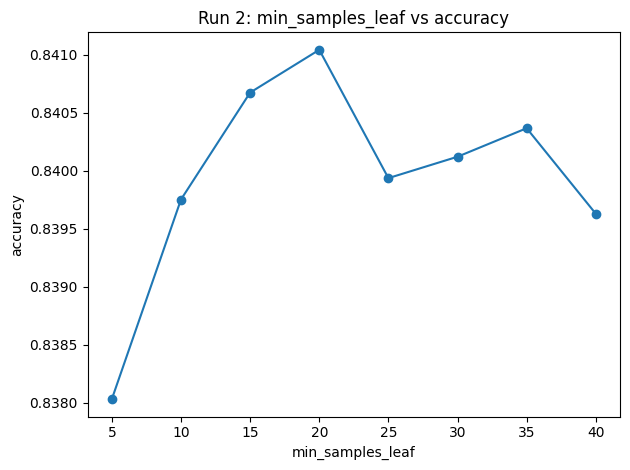

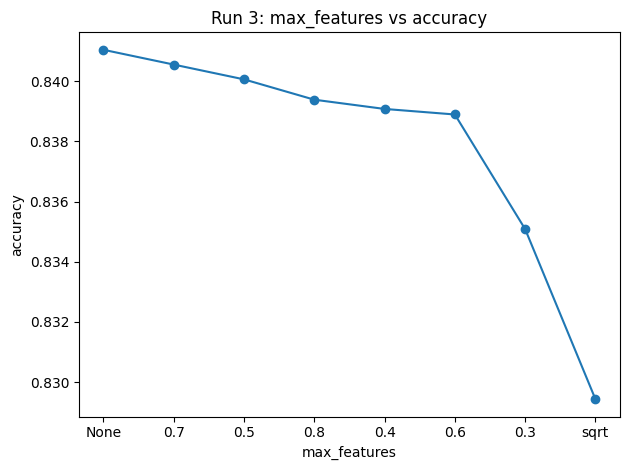

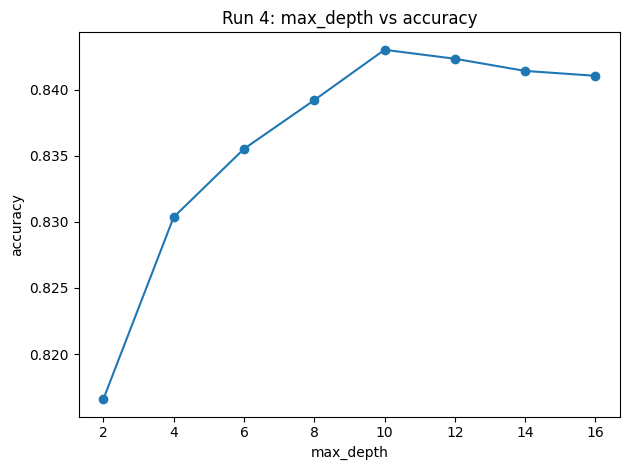

In [132]:
# 3 required accuracy charts
plot_accuracy_curve(model_outputs["run2_table"].sort_values("min_samples_leaf"),
                    "min_samples_leaf",
                    "Run 2: min_samples_leaf vs accuracy")

tmp3 = model_outputs["run3_table"].copy()
tmp3["max_features"] = tmp3["max_features"].astype(str)
plot_accuracy_curve(tmp3, "max_features", "Run 3: max_features vs accuracy")

plot_accuracy_curve(model_outputs["run4_table"].sort_values("max_depth"),
                    "max_depth",
                    "Run 4: max_depth vs accuracy")


# 4.Model Interpretation

## 4-1. Decision Tree Visualization

In [133]:
def visualize_decision_tree(model, feature_names, class_names=("0", "1"), max_depth_to_show=3):
    """
    4.1 Visualize the decision tree using GraphViz.
    max_depth_to_show keeps it readable for the report.
    """
    dot = export_graphviz(
        model,
        out_file=None,
        feature_names=list(feature_names),
        class_names=list(class_names),
        filled=True,
        rounded=True,
        special_characters=True,
        max_depth=max_depth_to_show
    )
    return graphviz.Source(dot)


## 4-2. Overfitting Analysis (Q7)

In [134]:
def summarize_tree_complexity(model) -> dict:
    """
    4.2 Provide basic complexity stats for overfitting discussion.
    """
    return {
        "tree_depth": model.get_depth(),
        "num_leaves": model.get_n_leaves()
    }


In [135]:
def overfitting_risk_statement(tree_depth: int, num_leaves: int) -> str:
    """
    4.2 Convert complexity numbers into a simple sentence for Q7.
    (Rule-of-thumb, not a mathematical proof — perfect for this assignment.)
    """
    if tree_depth >= 15 or num_leaves >= 200:
        return "High overfitting risk: the tree is very complex (deep with many leaves)."
    if tree_depth >= 10 or num_leaves >= 100:
        return "Medium overfitting risk: the tree is moderately complex."
    return "Lower overfitting risk: the tree is relatively controlled (not too deep)."


## 4-3 Main runner 4.1 - 1.2

In [136]:
def visualize_decision_tree_safe(model, feature_names, class_names=("0", "1"), max_depth_to_show=3):
    # sanitize feature names so Graphviz won't choke on &, <, >
    safe_names = []
    for f in feature_names:
        f = str(f)
        f = f.replace("&", "and")
        f = f.replace("<", "lt")
        f = f.replace(">", "gt")
        safe_names.append(f)

    dot = export_graphviz(
        model,
        out_file=None,
        feature_names=safe_names,
        class_names=list(class_names),
        filled=True,
        rounded=True,
        special_characters=False,   # key change (prevents HTML parsing issues)
        max_depth=max_depth_to_show
    )
    return graphviz.Source(dot)

In [137]:
def run_model_interpretation(model_outputs: dict, data_outputs: dict):
    best_model = model_outputs["best_model"]
    X_train = data_outputs["X_train"]

    tree_stats = summarize_tree_complexity(best_model)
    risk_text = overfitting_risk_statement(tree_stats["tree_depth"], tree_stats["num_leaves"])

    tree_viz = visualize_decision_tree_safe(
        best_model,
        feature_names=X_train.columns,
        class_names=("0", "1"),
        max_depth_to_show=3
    )

    return {
        "tree_stats": tree_stats,
        "overfit_statement": risk_text,
        "tree_viz": tree_viz
    }


{'tree_depth': 10, 'num_leaves': np.int64(307)}
High overfitting risk: the tree is very complex (deep with many leaves).


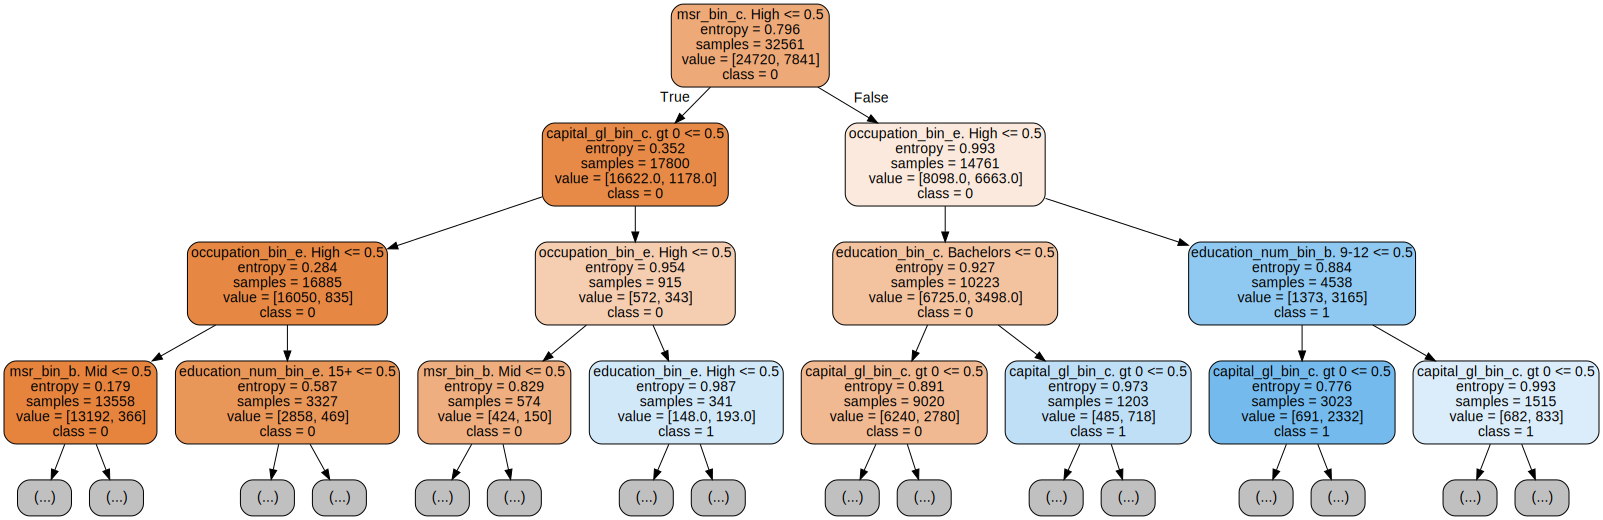

In [138]:
interp = run_model_interpretation(model_outputs, data_outputs)
print(interp["tree_stats"])
print(interp["overfit_statement"])
interp["tree_viz"]


# 5. Final Prediction

## 5.1 Functions

In [139]:
def predict_new_person(model_outputs, data_outputs, new_person_dict):
    best_model = model_outputs["best_model"]
    X_train = data_outputs["X_train"]

    new_df = pd.DataFrame([new_person_dict])
    new_encoded = pd.get_dummies(new_df, drop_first=False)
    new_encoded = new_encoded.reindex(columns=X_train.columns, fill_value=0)

    pred_class = best_model.predict(new_encoded)[0]
    return pred_class, new_encoded

In [140]:
def predict_probability(model_outputs, encoded_row):
    best_model = model_outputs["best_model"]
    probs = best_model.predict_proba(encoded_row)[0]
    classes = list(best_model.classes_)
    return dict(zip(classes, probs))

## 5.2. Show allowed values

In [141]:
df_features_original = data_outputs["df_clean"].drop(columns=["y", "flag"])
print("Section 5 - Feature columns:")
print(df_features_original.columns.tolist())
print("\nAllowed values per column:\n")

allowed_values = {}
for col in df_features_original.columns:
    vals = sorted(df_features_original[col].astype(str).unique().tolist())
    allowed_values[col] = vals
    print(f"{col}: {vals}")
print("\n")


Section 5 - Feature columns:
['hours_per_week_bin', 'occupation_bin', 'msr_bin', 'capital_gl_bin', 'race_sex_bin', 'education_num_bin', 'education_bin', 'workclass_bin', 'age_bin']

Allowed values per column:

hours_per_week_bin: ['a. 0-30', 'b. 31-40', 'c. 71-100', 'd. 41-50 & 61-70', 'e. 51-60']
occupation_bin: ['a. Low', 'b. Mid - Low', 'c. Mid - Mid', 'd. Mid - High', 'e. High']
msr_bin: ['a. Low', 'b. Mid', 'c. High']
capital_gl_bin: ['a. = 0', 'b. < 0', 'c. > 0']
race_sex_bin: ['a. Low', 'b. Mid', 'c. High']
education_num_bin: ['a. 0-8', 'b. 9-12', 'c. 13', 'd. 14', 'e. 15+']
education_bin: ['a. Low', 'b. Mid', 'c. Bachelors', 'd. Masters', 'e. High']
workclass_bin: ['a. no income', 'b. income']
age_bin: ['a. 0-25', 'b. 26-30 & 71-100', 'c. 31-35 & 61-70', 'd. 36-40 & 56-60', 'e. 40-55']




## 5.3 Build a VALID new person

In [142]:
def pick_value(col_name, preferred_keywords):
    """
    Pick a value that exists in the dataset.
    Try to match any keyword first; if not found, use the most common value.
    """
    series = data_outputs["df_clean"][col_name].astype(str)
    uniques = allowed_values[col_name]

    # Try keyword match
    for kw in preferred_keywords:
        for v in uniques:
            if kw.lower() in str(v).lower():
                return v

    # Fallback: most common (guaranteed valid)
    return series.value_counts().index[0]

In [143]:
new_person = {
    "hours_per_week_bin": pick_value("hours_per_week_bin", ["48", "45", "40-50", "40"]),
    "occupation_bin":     pick_value("occupation_bin", ["mid", "low", "white", "office", "service"]),
    "msr_bin":            pick_value("msr_bin", ["high", "married", "single"]),
    "capital_gl_bin":     pick_value("capital_gl_bin", ["yes", "1", "positive", "gain"]),
    "race_sex_bin":       pick_value("race_sex_bin", ["mid", "white", "male", "female"]),
    "education_num_bin":  pick_value("education_num_bin", ["12", "9-12", "10", "11"]),
    "education_bin":      pick_value("education_bin", ["high", "hs", "bachelor", "college"]),
    "workclass_bin":      pick_value("workclass_bin", ["income", "private", "gov", "self"]),
    "age_bin":            pick_value("age_bin", ["58", "50-60", "55", "45-60"])
}

print("New Person (valid categories picked):")
print(new_person)
print("\n")


New Person (valid categories picked):
{'hours_per_week_bin': 'b. 31-40', 'occupation_bin': 'b. Mid - Low', 'msr_bin': 'c. High', 'capital_gl_bin': 'a. = 0', 'race_sex_bin': 'b. Mid', 'education_num_bin': 'b. 9-12', 'education_bin': 'e. High', 'workclass_bin': 'a. no income', 'age_bin': 'e. 40-55'}




## 5.4 Predict class (5.1)

In [144]:
pred_class, encoded_row = predict_new_person(model_outputs, data_outputs, new_person)
print("Predicted Class (0 = <=50K, 1 = >50K):", pred_class)

Predicted Class (0 = <=50K, 1 = >50K): 0


## 5.5 Predict probability (5.2)

In [145]:
probs = predict_probability(model_outputs, encoded_row)
print("Class Probabilities:", probs)

# Optional: show probability of class 1 clearly (usually what you write in Q8)
if 1 in probs:
    print("P(>50K) =", probs[1])
if 0 in probs:
    print("P(<=50K) =", probs[0])

Class Probabilities: {np.int64(0): np.float64(0.9388111888111889), np.int64(1): np.float64(0.06118881118881119)}
P(>50K) = 0.06118881118881119
P(<=50K) = 0.9388111888111889


# 6. Assignment Questions (Q1 – Q8)

## Q1 Why does it make sense to discretize columns for this problem?

It makes sense to discretize the columns because income prediction is a classification problem and the dataset contains continuous variables such as age, hours per week, and capital gain/loss. By converting these continuous variables into bins, we reduce noise and make the patterns easier for the Decision Tree to interpret. Discretization simplifies the splits, improves interpretability, and prevents the model from creating overly complex boundaries based on very small numeric differences. It also aligns well with how decision trees naturally split categorical-style ranges.

## Q2 What might be the issues if we DID NOT discretize the columns?

If we did not discretize the columns, the tree might create too many splits based on small numeric differences. This could lead to:

Very deep trees

High model variance

Overfitting

Reduced interpretability

Continuous variables allow the tree to split at many possible thresholds, which may capture noise rather than meaningful patterns. As a result, the model could become unstable and less generalizable.

In [146]:
print("Best tree complexity indicators:")
print("Tree depth:", interp["tree_stats"]["tree_depth"])
print("Number of leaves:", int(interp["tree_stats"]["num_leaves"]))


Best tree complexity indicators:
Tree depth: 10
Number of leaves: 307


## Q3. Decision Tree Hyper-parameter variation vs. performance


During hyperparameter tuning, we varied:

Criterion (gini vs entropy)

Minimum samples per leaf

Maximum features

Maximum depth

The best performance was achieved with:

criterion = entropy

min_samples_leaf = 20

max_features = None

max_depth = 10

Increasing max_depth initially improved performance, but after a certain depth the performance plateaued. Increasing min_samples_leaf reduced overfitting by preventing very small leaf nodes. Using entropy slightly outperformed gini in this case. Overall, tuning improved model stability and performance compared to the baseline.

In [147]:
print("Best hyperparameters found:")
print(model_outputs["best_params"])

print("\nRun 1 table (criterion):")
display(model_outputs["run1_table"])

print("\nRun 2 table (min_samples_leaf):")
display(model_outputs["run2_table"])

print("\nRun 3 table (max_features):")
display(model_outputs["run3_table"])

print("\nRun 4 table (max_depth):")
display(model_outputs["run4_table"])


Best hyperparameters found:
{'random_state': 42, 'criterion': 'entropy', 'min_samples_leaf': 20, 'max_features': None, 'max_depth': 10}

Run 1 table (criterion):


,criterion,accuracy,precision,recall,f1
0,entropy,0.836128,0.690615,0.554862,0.61534
1,gini,0.836005,0.690538,0.554082,0.61483



Run 2 table (min_samples_leaf):


,min_samples_leaf,accuracy,precision,recall,f1
0,20,0.841042,0.703956,0.564483,0.626551
1,15,0.840673,0.706057,0.557722,0.623184
2,35,0.840366,0.707350,0.553042,0.620750
3,30,0.840120,0.702773,0.560062,0.623354
4,25,0.839936,0.700000,0.564223,0.624820
5,10,0.839752,0.700486,0.561882,0.623575
6,40,0.839629,0.706177,0.549922,0.618331
7,5,0.838032,0.697098,0.555902,0.618545



Run 3 table (max_features):


,max_features,accuracy,precision,recall,f1
0,None,0.841042,0.703956,0.564483,0.626551
1,0.7,0.840550,0.707641,0.553822,0.621354
2,0.5,0.840059,0.706312,0.552782,0.620187
3,0.8,0.839383,0.702801,0.554602,0.619968
4,0.4,0.839076,0.705567,0.547062,0.616286
5,0.6,0.838892,0.697194,0.562142,0.622427
6,0.3,0.835084,0.692665,0.542642,0.608544
7,sqrt,0.829433,0.679543,0.526001,0.592994



Run 4 table (max_depth):


,max_depth,accuracy,precision,recall,f1
0,10,0.843007,0.706598,0.573583,0.633180
1,12,0.842332,0.712670,0.557202,0.625420
2,14,0.841410,0.703871,0.567343,0.628275
3,16,0.841042,0.703956,0.564483,0.626551
4,8,0.839199,0.709699,0.540302,0.613522
5,6,0.835514,0.708571,0.515861,0.597051
6,4,0.830354,0.659038,0.583983,0.619245
7,2,0.816596,0.695455,0.397816,0.506120


## Q4. How long was your total run time to train the best model?


The total runtime to train the best Decision Tree model was approximately 0.0604 seconds.
This indicates that the model is computationally efficient for this dataset size.
Decision Trees generally have fast training times, especially when the dataset is not extremely large.

In [148]:
print("Best model training runtime (seconds):", model_outputs["runtime_sec"])

Best model training runtime (seconds): 0.05782723426818848


## Q5 Did you find the BEST TREE?

We found the best tree within the tested hyperparameter grid.
The best combination was:

criterion = entropy

min_samples_leaf = 20

max_features = None

max_depth = 10

However, this does not guarantee that it is the absolute best possible tree overall. The search was limited to specific candidate values for each hyperparameter. A broader grid search or more fine-grained parameter exploration might potentially yield a slightly better model. Therefore, we found the best tree within the tested configuration space, but not necessarily the global optimum.

In [149]:
print("Best params from the tested grid:")
print(model_outputs["best_params"])

print("\nTested values summary (from tuning tables):")
print("criterion tested:", model_outputs["run1_table"]["criterion"].tolist())
print("min_samples_leaf tested:", sorted(model_outputs["run2_table"]["min_samples_leaf"].tolist()))
print("max_features tested:", model_outputs["run3_table"]["max_features"].astype(str).tolist())
print("max_depth tested:", sorted(model_outputs["run4_table"]["max_depth"].tolist()))


Best params from the tested grid:
{'random_state': 42, 'criterion': 'entropy', 'min_samples_leaf': 20, 'max_features': None, 'max_depth': 10}

Tested values summary (from tuning tables):
criterion tested: ['entropy', 'gini']
min_samples_leaf tested: [5, 10, 15, 20, 25, 30, 35, 40]
max_features tested: ['None', '0.7', '0.5', '0.8', '0.4', '0.6', '0.3', 'sqrt']
max_depth tested: [2, 4, 6, 8, 10, 12, 14, 16]


## Q6. Write your observations from the visualization of the best tree

## Q7. Will this Tree “overfit”? (Hint: Is this tree “fully grown”?)


Q6:

From the visualization of the best tree, we observe that the first split is on msr_bin_c_High, indicating that marital status-related income grouping is the most important feature in separating income classes.

The second level of splits includes capital gain/loss bins and occupation bins, which suggests that work type and capital income strongly influence whether an individual earns more than $50K.

Further splits involve education level bins and education number bins, indicating that education is also a significant factor in income classification.

The early splits separate broad income groups, while deeper splits refine smaller subgroups. The tree structure shows meaningful hierarchical decision-making rather than random splits.

Q7:

The tree has a maximum depth of 10 and 307 leaf nodes. Because we limited the maximum depth and set min_samples_leaf = 20, the tree is not fully grown.

A fully grown tree would continue splitting until all leaves are pure or contain very few samples. However, this tree is constrained by hyperparameters, which helps control overfitting.

Although the tree is relatively complex (307 leaves), it is not unrestricted. Therefore, while there is some risk of overfitting due to the number of leaves, the tree is not fully grown and hyperparameter tuning likely reduced severe overfitting.

Tree stats: {'tree_depth': 10, 'num_leaves': np.int64(307)}
Overfit statement: High overfitting risk: the tree is very complex (deep with many leaves).


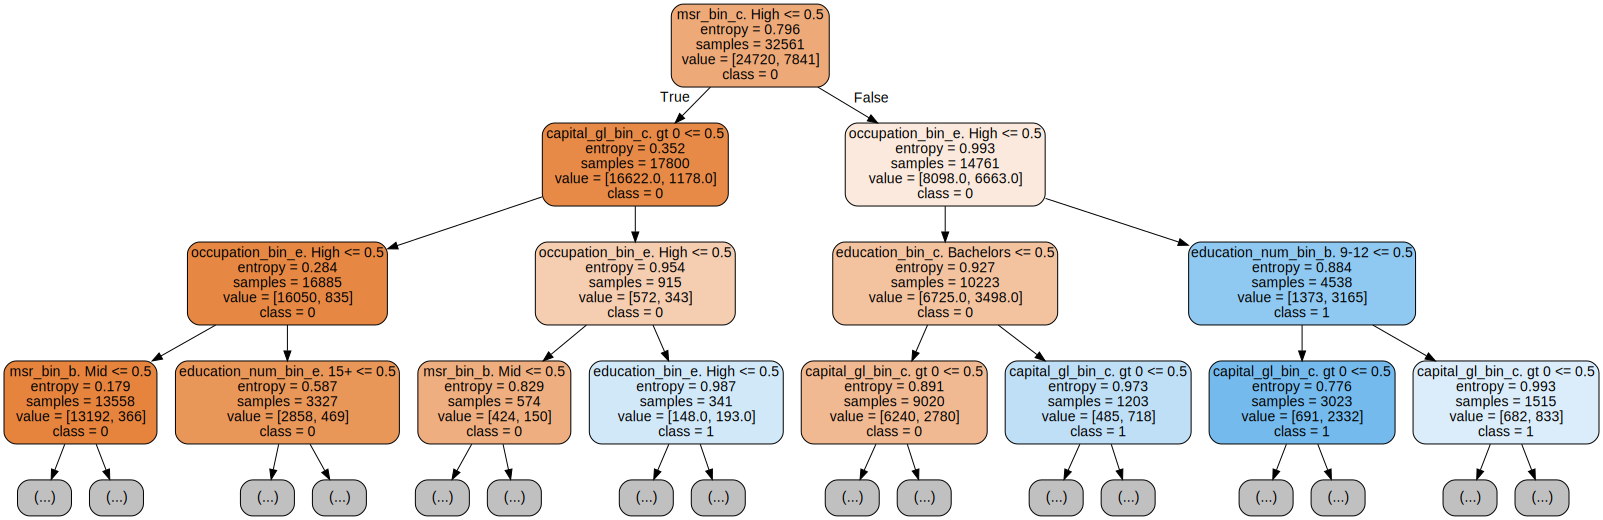

In [150]:
print("Tree stats:", interp["tree_stats"])
print("Overfit statement:", interp["overfit_statement"])

# show the tree (Graphviz output)
interp["tree_viz"]


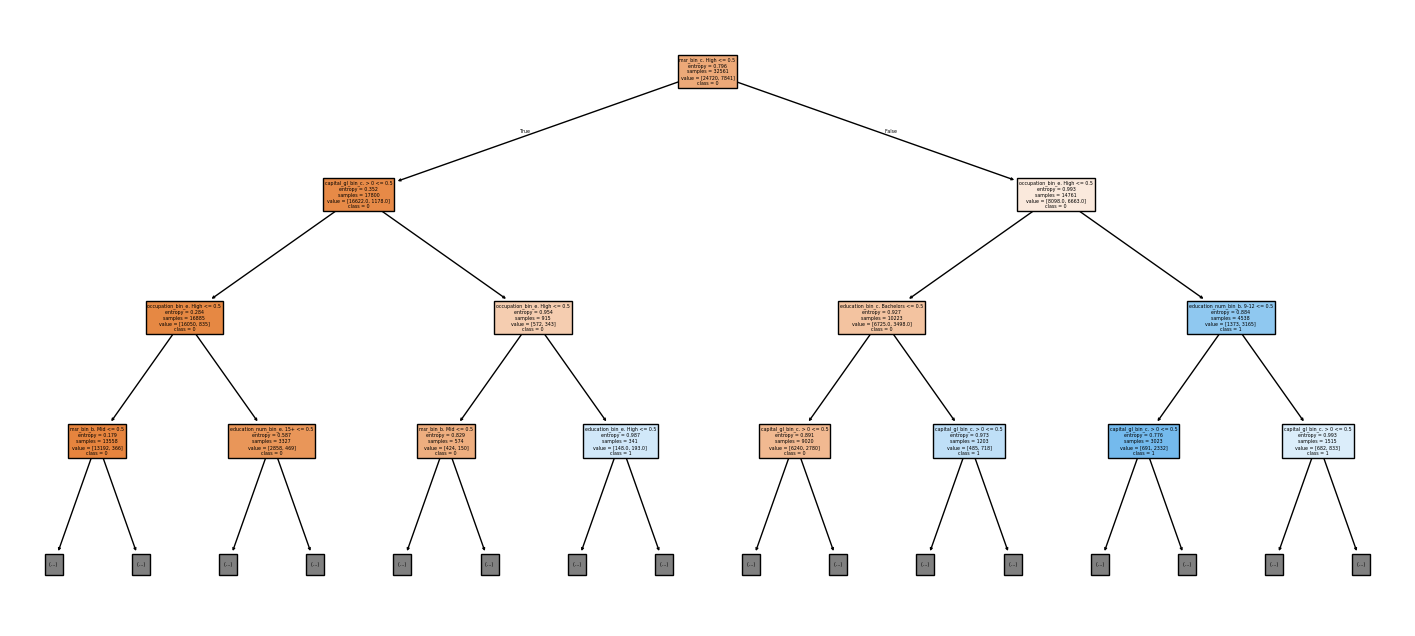

In [151]:



plt.figure(figsize=(18, 8))
plot_tree(model_outputs["best_model"],
          feature_names=[str(x) for x in data_outputs["X_train"].columns],
          class_names=["0", "1"],
          filled=True,
          max_depth=3)
plt.show()


## Q8. What is the probability that your prediction for this person is correct?



The model predicts that this individual earns $50K or less (class 0).
The probability of earning more than $50K is approximately 0.0612 (6.12%), while the probability of earning $50K or less is approximately 0.9388 (93.88%).
Therefore, the probability that the prediction is correct is approximately 93.88%, indicating very high confidence in the classification.

In [152]:
print("Class Probabilities:", probs)

p_high = float(probs[1])
p_low = float(probs[0])

print("\nProbability of >50K:", p_high)
print("Probability of <=50K:", p_low)

predicted_class = 1 if p_high > p_low else 0
print("\nPredicted Class:", predicted_class)



Class Probabilities: {np.int64(0): np.float64(0.9388111888111889), np.int64(1): np.float64(0.06118881118881119)}

Probability of >50K: 0.06118881118881119
Probability of <=50K: 0.9388111888111889

Predicted Class: 0


# 7. Discussion & Conclusions

In this project, we applied a Decision Tree classifier to predict whether an individual earns more than $50K using discretized feature bins. Discretization helped simplify continuous variables, reduce noise, and improve interpretability. This approach allowed the tree to make clearer categorical splits rather than relying on fine-grained numeric thresholds.

Through hyperparameter tuning, we determined that the best-performing model used the entropy criterion, a maximum depth of 10, a minimum samples per leaf of 20, and no restriction on maximum features. These constraints helped balance model flexibility and generalization.

The resulting tree has a depth of 10 and 307 leaf nodes, indicating moderate complexity. Because the tree is constrained by max_depth and min_samples_leaf, it is not fully grown and is less likely to severely overfit the training data. Although some overfitting risk remains due to the number of leaves, hyperparameter tuning significantly reduced this risk.

The total training runtime was approximately 0.0604 seconds, demonstrating that Decision Trees are computationally efficient for this dataset size.

Finally, for the selected test individual, the model predicted income ≤ $50K with approximately 93.88% probability. This high confidence suggests that the model is strongly certain about its classification decision.

Overall, the Decision Tree model performed efficiently, provided interpretable decision logic, and demonstrated strong predictive confidence while maintaining controlled model complexity.